### Connect to Drive

In [1]:
#from google.colab import drive
#drive.mount('/gdrive')

In [2]:
#%cd /gdrive/My Drive/ANN&DL/hw2



In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/training/Training.csv


### Import libraries

In [4]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.6.2


### Set seed for reproducibility

In [5]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

### Exploration Data Analysis (EDA)


Load the dataset

In [6]:
#dataset = pd.read_csv('Training.csv')
#print(dataset.shape)
#dataset.head()

In [7]:
dataset = pd.read_csv('../input/training/Training.csv',
                     low_memory = False)
print(dataset.shape)
dataset.head()

(68528, 7)


,Sponginess,Wonder level,Crunchiness,Loudness on impact,Meme creativity,Soap slipperiness,Hype root
0,7.97698,4.33494,10.67282,1.76692,3.22440,51.681460,3.65434
1,8.07824,4.44616,10.56160,1.70716,3.32566,51.563598,3.47672
2,8.02844,4.22372,10.56160,1.64906,3.17460,50.863080,3.47672
3,8.02844,4.22372,10.56160,1.70716,3.17460,45.841581,3.47672
4,7.87572,4.44616,10.45038,1.70716,3.27586,47.126421,3.47672


In [8]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68528 entries, 0 to 68527
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Sponginess          68528 non-null  float64
 1   Wonder level        68528 non-null  float64
 2   Crunchiness         68528 non-null  float64
 3   Loudness on impact  68528 non-null  float64
 4   Meme creativity     68528 non-null  float64
 5   Soap slipperiness   68528 non-null  float64
 6   Hype root           68528 non-null  float64
dtypes: float64(7)
memory usage: 3.7 MB


In [9]:
# Set hyperparameters
test_size = 1152
remove = 1136
window = 576
stride = 24
telescope = 288

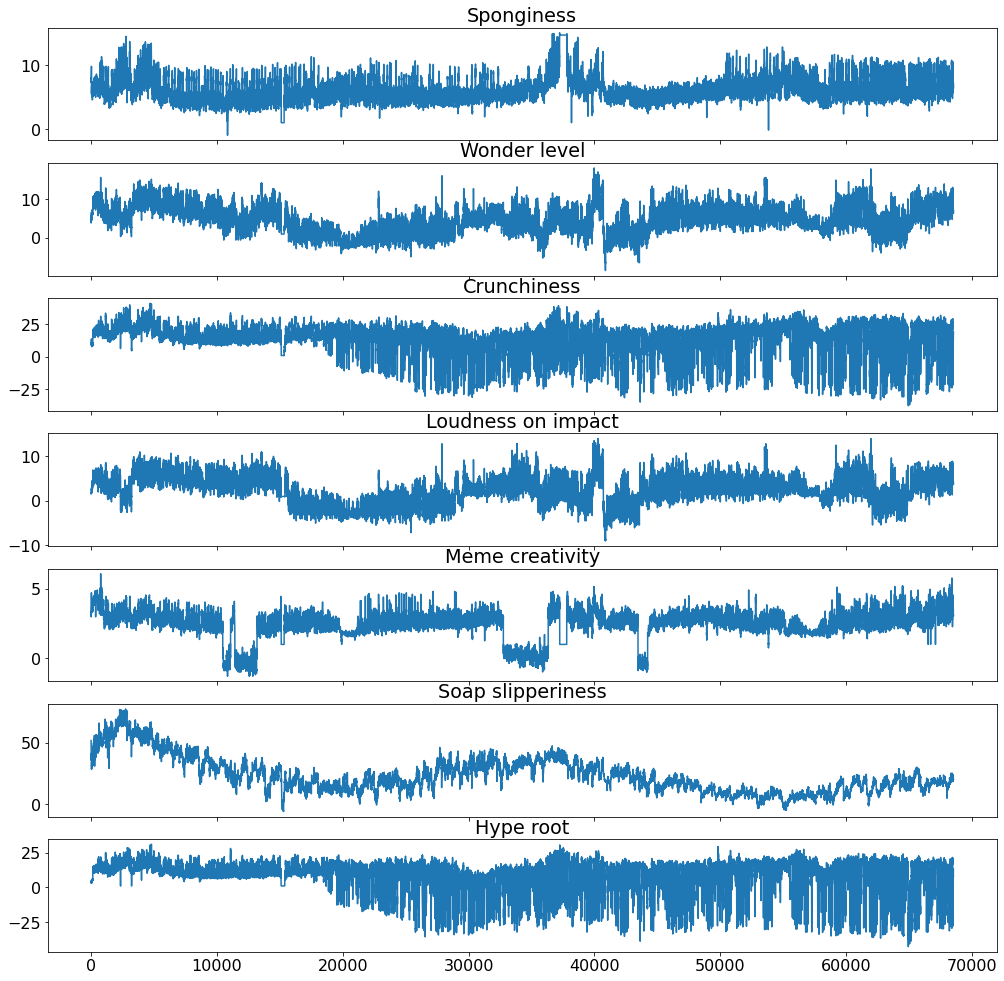

In [10]:
def inspect_dataframe(df, columns):
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(df[col])
        axs[i].set_title(col)
    plt.show()
inspect_dataframe(dataset, dataset.columns)

Sequential Train-Test split and normalization

(67376, 7) (1152, 7)


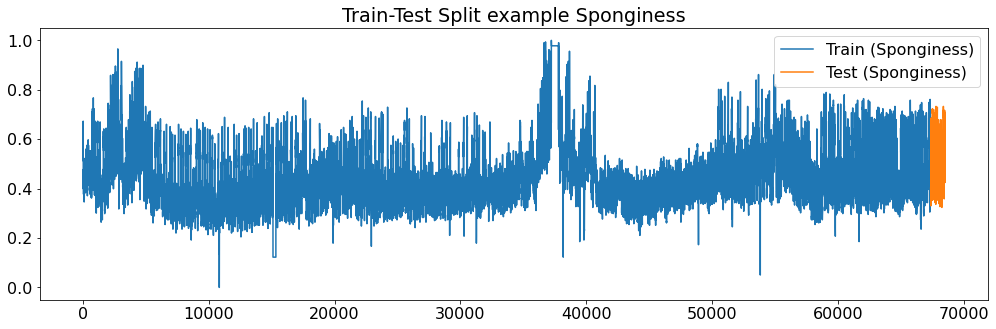

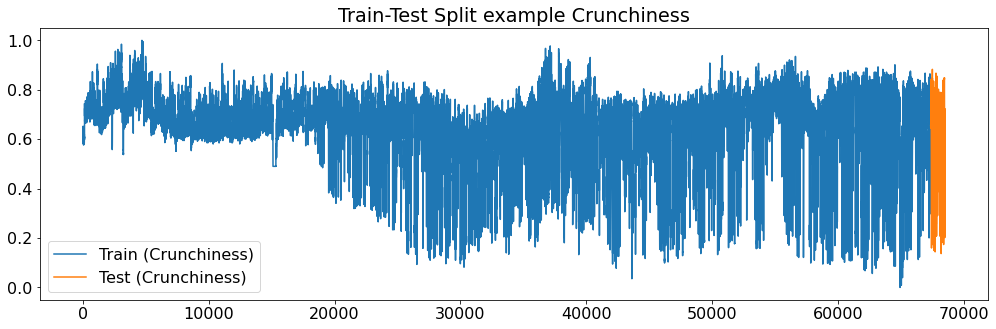

In [11]:
X_train_raw = dataset.iloc[:-test_size]
# y_train_raw = y.iloc[:-test_size]
X_test_raw = dataset.iloc[-test_size:]
# y_test_raw = y.iloc[-test_size:]
print(X_train_raw.shape, X_test_raw.shape)

# Normalize both features and labels
X_min = X_train_raw.min()
X_max = X_train_raw.max()

X_train_raw = (X_train_raw-X_min)/(X_max-X_min)
X_test_raw = (X_test_raw-X_min)/(X_max-X_min)

plt.figure(figsize=(17,5))
plt.plot(X_train_raw.Sponginess, label='Train (Sponginess)')
plt.plot(X_test_raw.Sponginess, label='Test (Sponginess)')
plt.title('Train-Test Split example Sponginess')
plt.legend()
plt.show()

plt.figure(figsize=(17,5))
plt.plot(X_train_raw.Crunchiness, label='Train (Crunchiness)')
plt.plot(X_test_raw.Crunchiness, label='Test (Crunchiness)')
plt.title('Train-Test Split example Crunchiness')
plt.legend()
plt.show()


In [12]:
def build_sequences(df, target_labels=['Sponginess'], window=200, stride=20, telescope=100):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []
    temp_df = df.copy().values
    temp_label = df[target_labels].copy().values
    padding_len = len(df)%window
    # We don't want padding
    #print(len(df))
    #print(padding_len)
    #assert padding_len == 0

    if(padding_len != 0):
        # Compute padding length
        padding_len = window - len(df)%window
        padding = np.zeros((padding_len,temp_df.shape[1]), dtype='float64')
        temp_df = np.concatenate((padding,df))
        padding = np.zeros((padding_len,temp_label.shape[1]), dtype='float64')
        temp_label = np.concatenate((padding,temp_label))
        assert len(temp_df) % window == 0

    for idx in np.arange(0,len(temp_df)-window-telescope,stride):
        dataset.append(temp_df[idx:idx+window])
        labels.append(temp_label[idx+window:idx+window+telescope])

        
    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

In [13]:
target_labels = dataset.columns
#telescope = 100

In [14]:
X_train, y_train = build_sequences(X_train_raw, target_labels, window, stride, telescope)
X_test, y_test = build_sequences(X_test_raw, target_labels, window, stride, telescope)
X_train.shape, y_train.shape , X_test.shape, y_test.shape

((2772, 576, 7), (2772, 288, 7), (12, 576, 7), (12, 288, 7))

In [15]:
def inspect_multivariate(X, y, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].scatter(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()

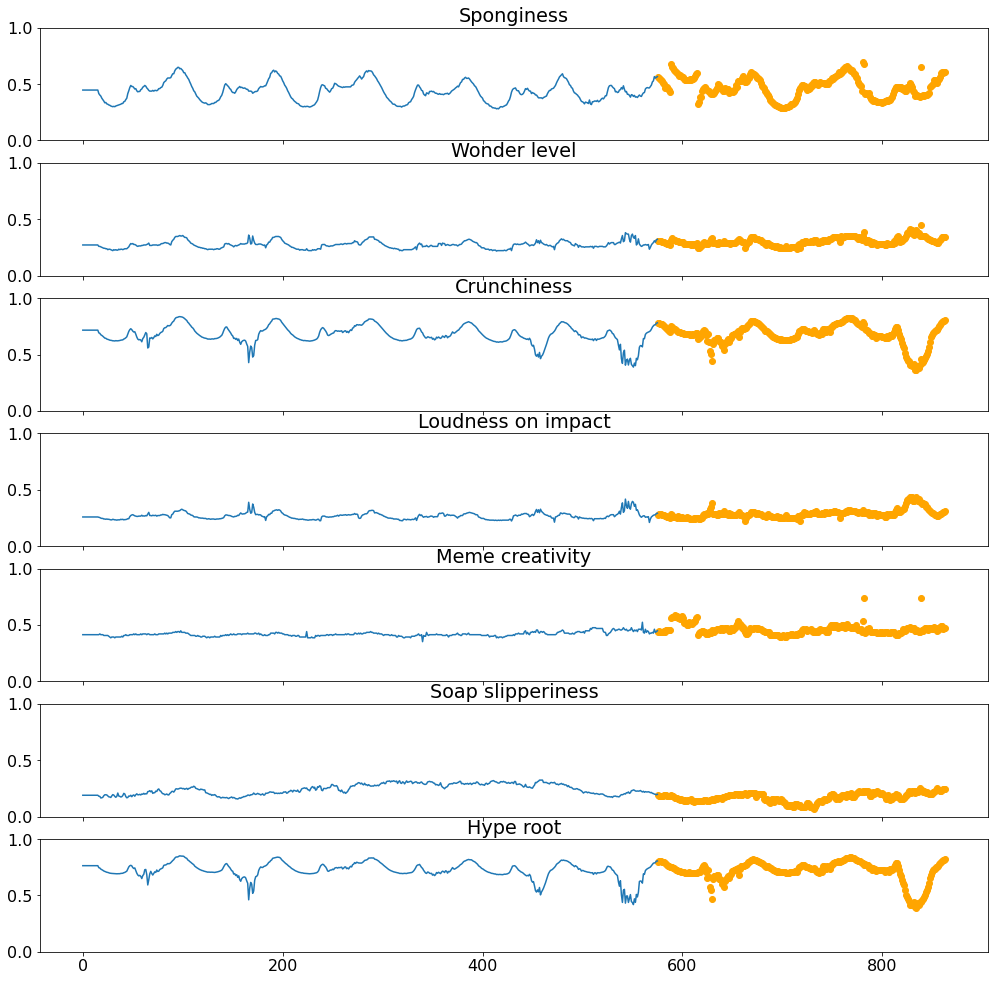

In [16]:
inspect_multivariate(X_train, y_train, target_labels, telescope)

In [17]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 64
epochs = 200

In [18]:
def build_model(input_shape, output_shape):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    convlstm = tfkl.Bidirectional(tfkl.LSTM(64, return_sequences=True))(input_layer)
    convlstm = tfkl.Conv1D(128, 3, padding='same', activation='relu')(convlstm)
    convlstm = tfkl.MaxPool1D()(convlstm)

    convlstm = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True))(convlstm)
    convlstm = tfkl.Conv1D(256, 3, padding='same', activation='relu')(convlstm)
    convlstm = tfkl.MaxPool1D()(convlstm)

    convlstm = tfkl.Bidirectional(tfkl.LSTM(256, return_sequences=True))(convlstm)
    convlstm = tfkl.Conv1D(512, 3, padding='same', activation='relu')(convlstm)
    convlstm = tfkl.GlobalAveragePooling1D()(convlstm)

    convlstm = tfkl.Dropout(.5)(convlstm)
    #convlstm = tfkl.Bidirectional(tfkl.LSTM(32, return_sequences=True))(input_layer)
    #convlstm = tfkl.Bidirectional(tfkl.LSTM(64, return_sequences=True))(convlstm)
    #convlstmg11 = tfkl.Conv1D(128, 4, padding='same', activation='relu')(convlstm)
    #convlstm = tfkl.MaxPool1D()(convlstmg11)
    #convlstmg21 = tfkl.Conv1D(256, 4, padding='same', activation='relu')(convlstm)
    #convlstm = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True))(convlstm)
    #convlstm = tfkl.LSTM(256, return_sequences=True)(convlstm)
    #convlstm = tfkl.GlobalAveragePooling1D()(convlstm)
    #dropout = tfkl.Dropout(.3)(convlstm)

    # In order to predict the next values for more than one channel,
    # we can use a Dense layer with a number given by telescope*num_channels,
    # followed by a Reshape layer to obtain a tensor of dimension 
    # [None, telescope, num_channels]
    #dense = tfkl.Dense(output_shape[-1]*output_shape[-2], activation='relu')(convlstm)
    #output_layer = tfkl.Reshape((output_shape[-2],output_shape[-1]))(dense)
    #output_layer = tfkl.Conv1D(output_shape[-1], 1, padding='same')(output_layer)
    
    
    #########################################################
    # easy net

    # Feature extractor
    #lstm =  tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True))(input_layer)
    #lstm2 =  tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True))(lstm)
    #lstm3 =  tfkl.Bidirectional(tfkl.LSTM(128))(lstm2)
    #lstm3 = tfkl.LSTM(128, return_sequences=True)(input_layer)
    #lstm4 = tfkl.LSTM(128)(lstm3)
    #fake_lstm = tfkl.LSTM(8)(input_layer)
    #dropout = tfkl.Dropout(.3, seed=seed)(lstm3)


    # In order to predict the next values for more than one channel,
    # we can use a Dense layer with a number given by telescope*num_channels,
    # followed by a Reshape layer to obtain a tensor of dimension 
    # [None, telescope, num_channels]
    dense = tfkl.Dense(output_shape[-1]*output_shape[-2], activation='relu')(convlstm)
    output_layer = tfkl.Reshape((output_shape[-2],output_shape[-1]))(dense)
    output_layer = tfkl.Conv1D(output_shape[-1], 1, padding='same')(output_layer)
    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(), metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')])

    # Return the model
    return model

2022-01-11 20:24:42.157168: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-11 20:24:42.242741: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-11 20:24:42.243837: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-11 20:24:42.245846: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 576, 7)]          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 576, 128)          36864     
_________________________________________________________________
conv1d (Conv1D)              (None, 576, 128)          49280     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 288, 128)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 288, 256)          263168    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 288, 256)          196864    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 144, 256)          0     

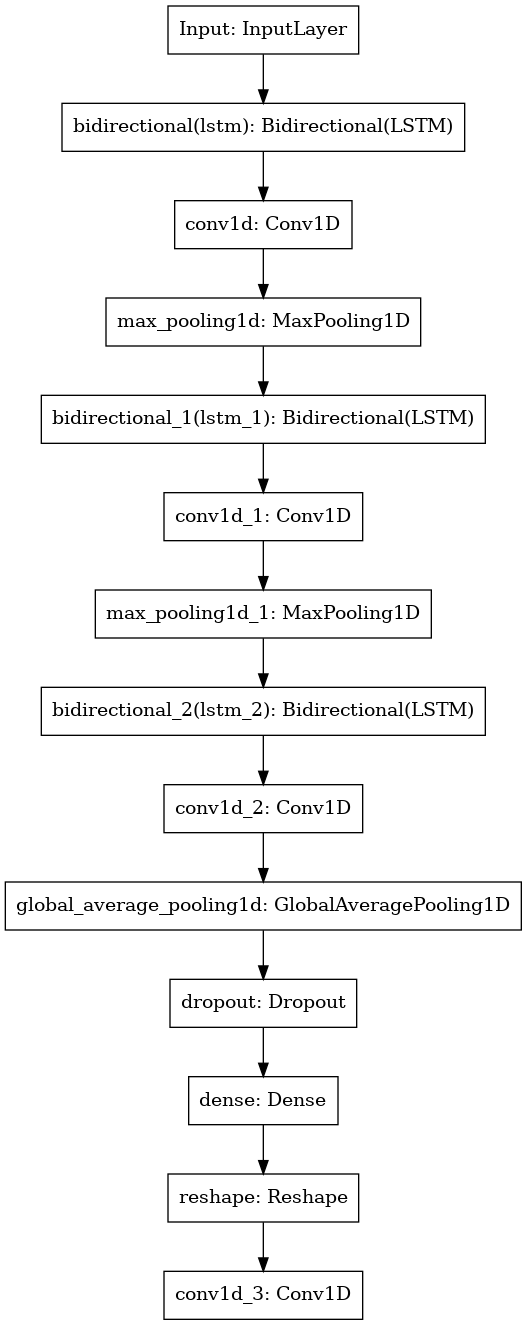

In [19]:
model = build_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True)

In [20]:
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history


2022-01-11 20:24:46.924242: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200


2022-01-11 20:24:54.132698: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


39/39 [==============================] - 20s 184ms/step - loss: 0.2516 - rmse: 0.5016 - val_loss: 0.2096 - val_rmse: 0.4578
Epoch 2/200
39/39 [==============================] - 5s 140ms/step - loss: 0.1738 - rmse: 0.4169 - val_loss: 0.1379 - val_rmse: 0.3713
Epoch 3/200
39/39 [==============================] - 5s 139ms/step - loss: 0.1076 - rmse: 0.3281 - val_loss: 0.0845 - val_rmse: 0.2907
Epoch 4/200
39/39 [==============================] - 6s 141ms/step - loss: 0.0651 - rmse: 0.2552 - val_loss: 0.0539 - val_rmse: 0.2322
Epoch 5/200
39/39 [==============================] - 5s 140ms/step - loss: 0.0399 - rmse: 0.1998 - val_loss: 0.0369 - val_rmse: 0.1922
Epoch 6/200
39/39 [==============================] - 5s 139ms/step - loss: 0.0261 - rmse: 0.1616 - val_loss: 0.0282 - val_rmse: 0.1679
Epoch 7/200
39/39 [==============================] - 5s 140ms/step - loss: 0.0205 - rmse: 0.1431 - val_loss: 0.0251 - val_rmse: 0.1584
Epoch 8/200
39/39 [==============================] - 5s 140ms/step

In [21]:
model.save('TimeSeries')
#model = tfk.models.load_model('DirectForecasting')

2022-01-11 20:29:27.648315: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


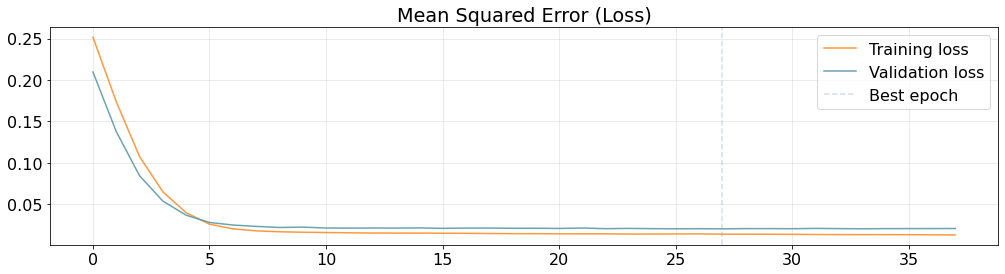

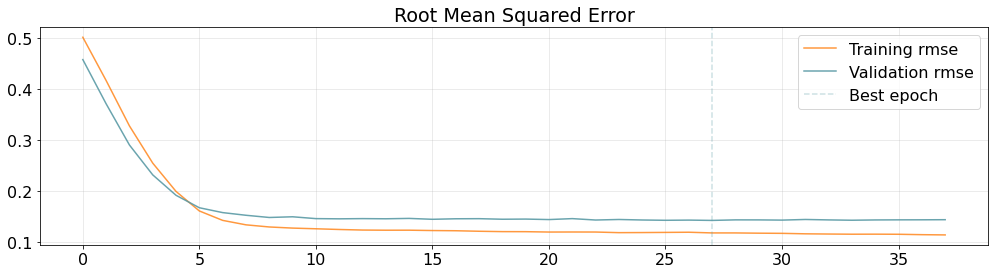

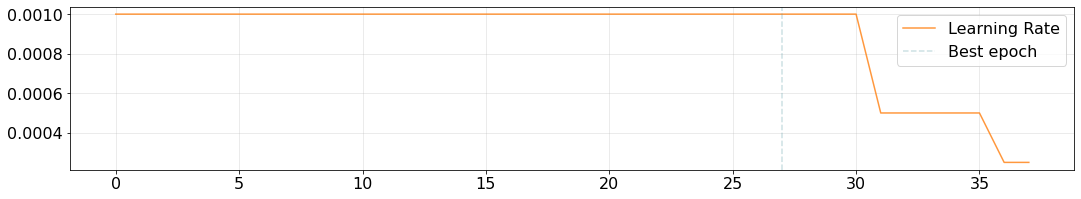

In [22]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error (Loss)')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['rmse'], label='Training rmse', alpha=.8, color='#ff7f0e')
plt.plot(history['val_rmse'], label='Validation rmse', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Root Mean Squared Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()



Test evaluation

In [23]:
# Predict the test set 
predictions = model.predict(X_test)
print(predictions.shape)


rms = tfk.metrics.RootMeanSquaredError()
rms = rms.update_state(y_test.flatten(),predictions.flatten())
root_mean_squared_error = rms.read_value()

mean_squared_error = tfk.metrics.mse(y_test.flatten(),predictions.flatten())
mean_absolute_error = tfk.metrics.mae(y_test.flatten(),predictions.flatten())
mean_squared_error, mean_absolute_error, root_mean_squared_error

(12, 288, 7)


(<tf.Tensor: shape=(), dtype=float32, numpy=0.024029747>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.10682377>,
 <tf.Tensor: shape=(), dtype=float32, numpy=24192.0>)

In [24]:
def inspect_multivariate_prediction(X, y, pred, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].scatter(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].scatter(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), pred[idx,:,i], color='green')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()

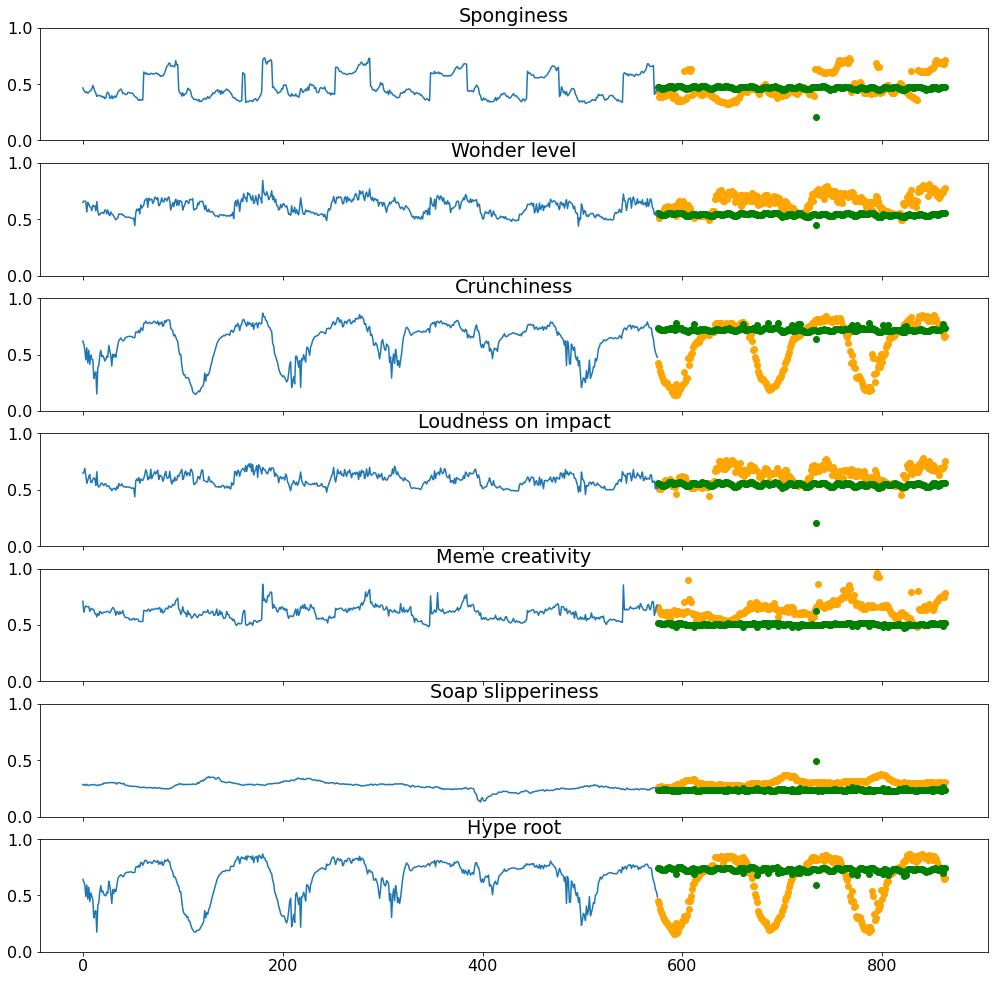

In [25]:
inspect_multivariate_prediction(X_test, y_test, predictions, target_labels, telescope)

Predict the future 

(12, 288, 7)


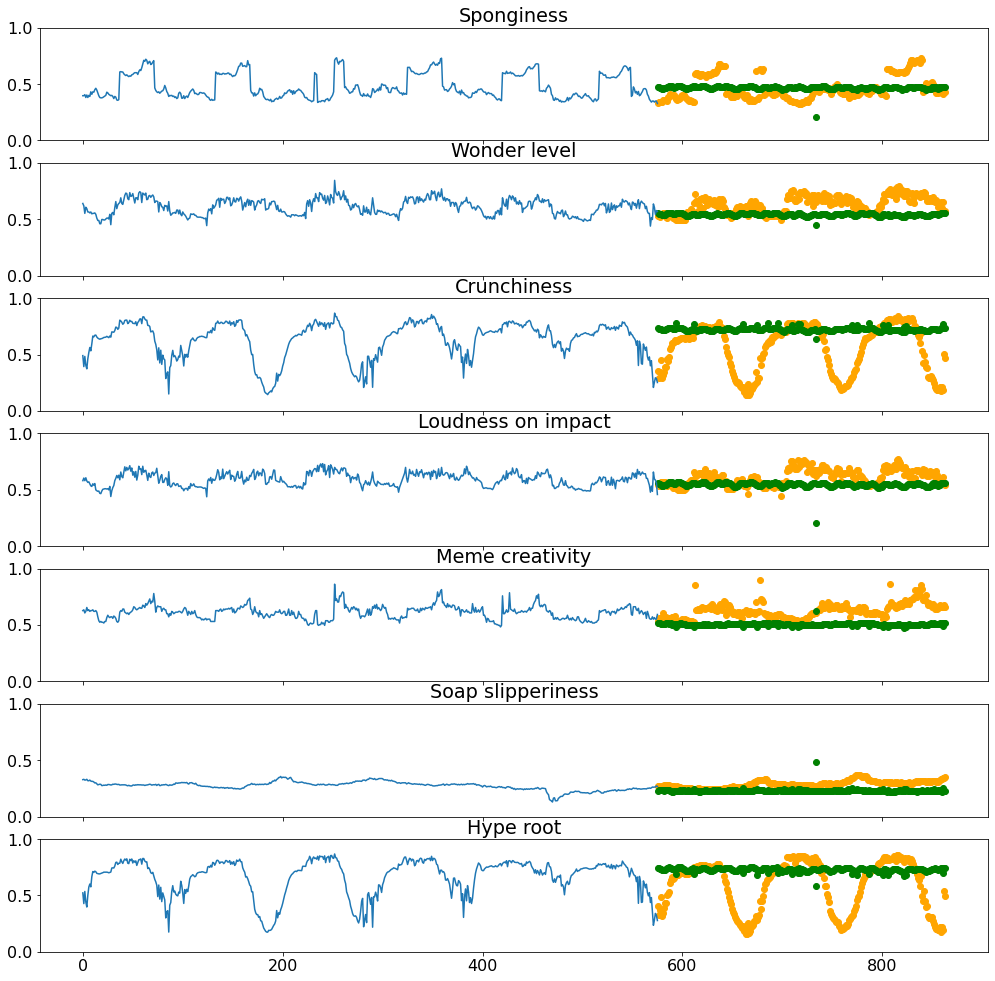

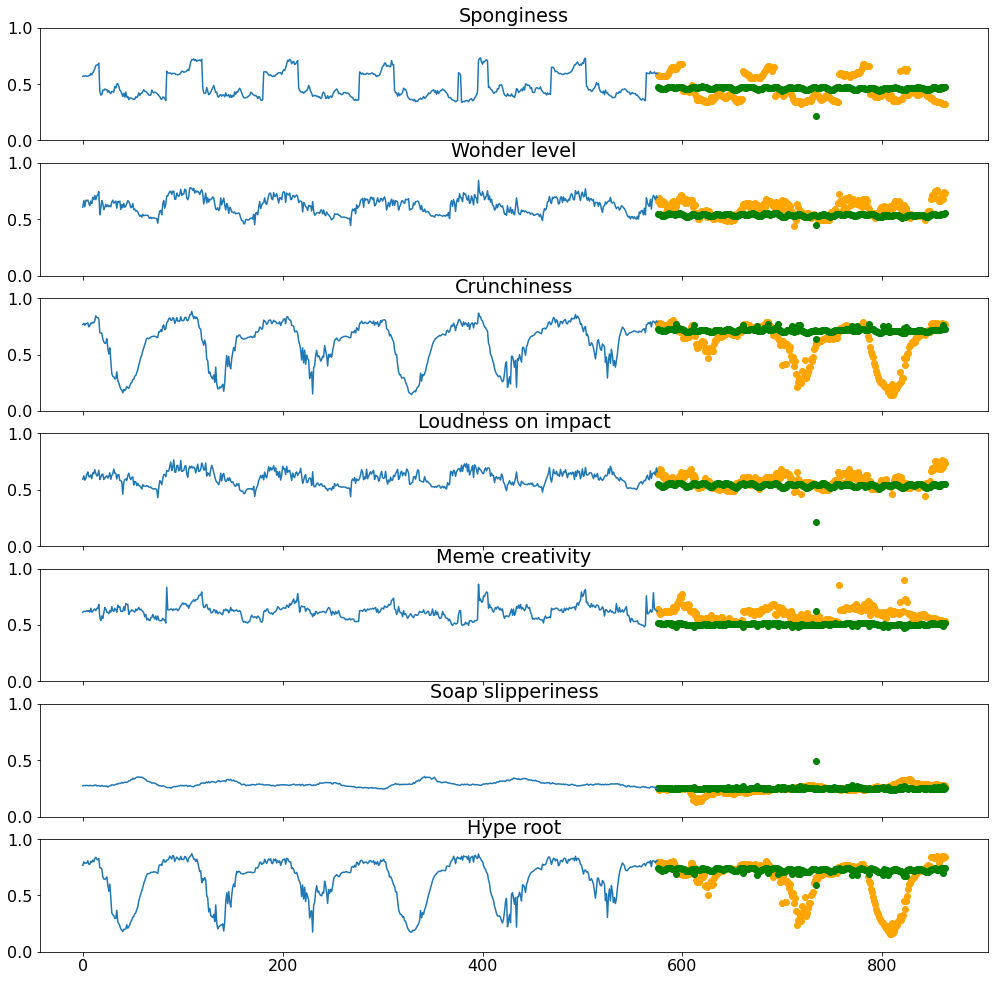

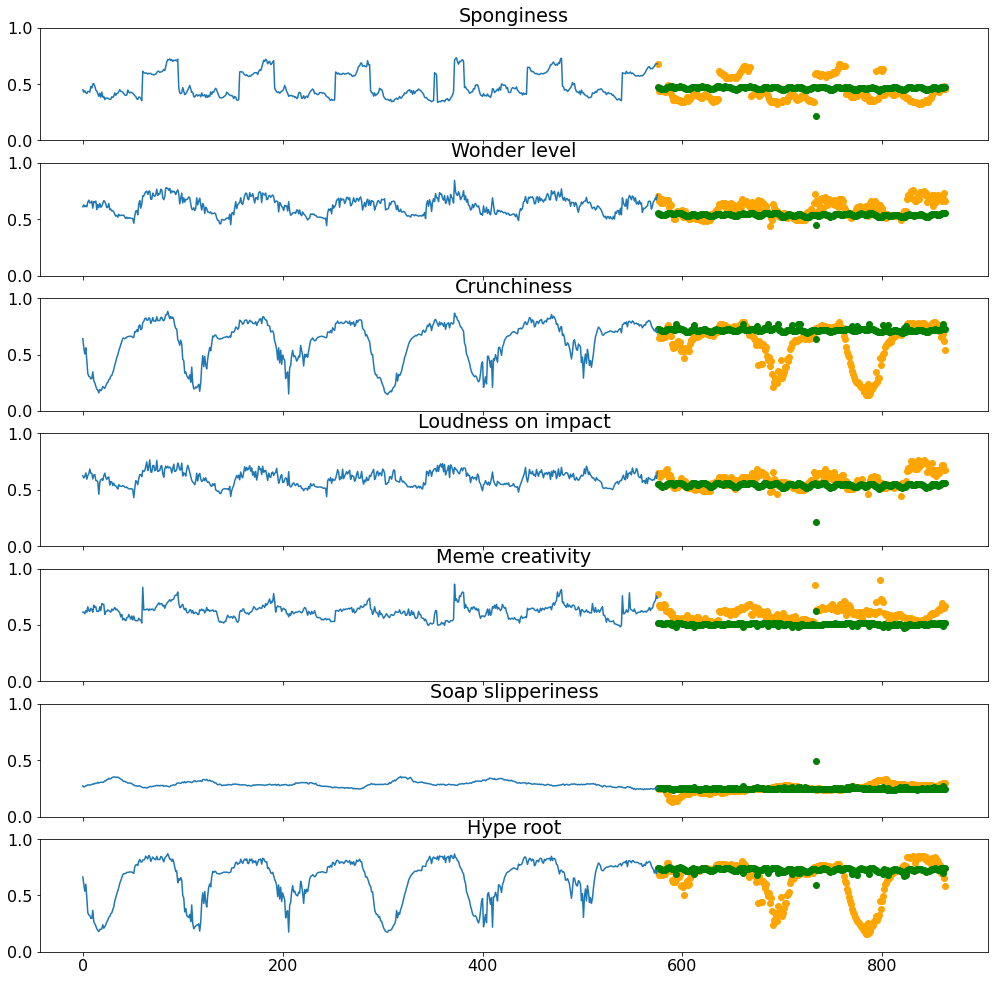

In [26]:
# Predict the test set 
predictions = model.predict(X_test)
print(predictions.shape)

# Reorganize test sequences
if (telescope==1): 
    reg_telescope = 144
    X_test_reg, y_test_reg = build_sequences(X_test_raw, target_labels, window, stride, reg_telescope)
    X_test_reg.shape, y_test_reg.shape

    reg_predictions = np.array([])
    X_temp = X_test_reg
    for reg in range(reg_telescope):
        pred_temp = model.predict(X_temp)
        if(len(reg_predictions)==0):
            reg_predictions = pred_temp
        else:
            reg_predictions = np.concatenate((reg_predictions,pred_temp),axis=1)
        X_temp = np.concatenate((X_temp[:,1:,:],pred_temp), axis=1)
    # Show some sequences
    inspect_multivariate_prediction(X_test_reg, y_test_reg, reg_predictions, target_labels, reg_telescope, 0)
    inspect_multivariate_prediction(X_test_reg, y_test_reg, reg_predictions, target_labels, reg_telescope, 1)
    inspect_multivariate_prediction(X_test_reg, y_test_reg, reg_predictions, target_labels, reg_telescope, 2)
else:
    # Show some sequences
    inspect_multivariate_prediction(X_test, y_test, predictions, target_labels, telescope)
    inspect_multivariate_prediction(X_test, y_test, predictions, target_labels, telescope, 1)
    inspect_multivariate_prediction(X_test, y_test, predictions, target_labels, telescope, 2)

In [27]:
## Test like in model

reg_future = np.array([])
X_temp = tf.convert_to_tensor(X_train_raw)[-window:]
X_temp = np.expand_dims(X_temp, axis=0)
print(X_temp.shape)

X_temp_pred = X_temp[0]
X_temp_pred = X_temp_pred[-window:]
X_temp_pred = np.expand_dims(X_temp_pred, axis=0)

for i in range(test_size//telescope):
    #print(X_temp_pred.shape)
    pred_temp = model.predict(X_temp_pred)
    if(len(reg_future)==0):
        reg_future = pred_temp
    else:
        reg_future = np.concatenate((reg_future,pred_temp),axis=1)
    X_temp_pred = np.concatenate((X_temp_pred[:,telescope:,:],pred_temp), axis=1)
print(reg_future.shape)  

(1, 576, 7)
(1, 1152, 7)


(1152, 7)
(1152, 7)
Rmse: 
8064.0


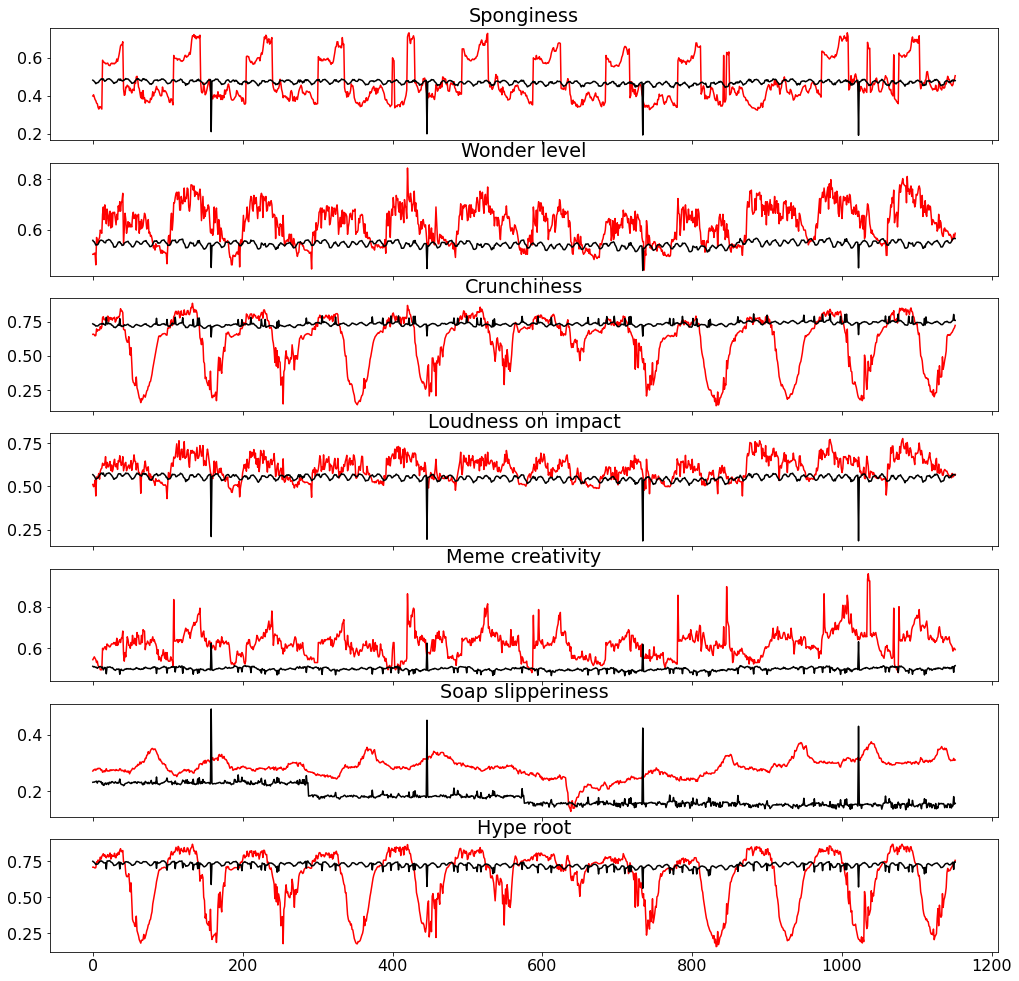

In [28]:
reg_future = tf.reshape(reg_future, [test_size, 7])
print(reg_future.shape)

X_test_print = tf.convert_to_tensor(X_test_raw)
print(X_test_print.shape)

#compute rmse
rms = tfk.metrics.RootMeanSquaredError()
rms = rms.update_state(reg_future,X_test_print)
rmse = rms.read_value()
print("Rmse: ")
print(rmse.numpy())


#pred_plt = np.array([])
#for i in range(4):
    #if(len(pred_plt)==0):
        #pred_plt = np.zeros([144, 7])
    #else:
        #pred_plt = np.concatenate((pred_plt,predictions[i-1]),axis=0)
#print(pred_plt.shape)

# plot 
figs, axs = plt.subplots(len(dataset.columns), 1, sharex=True, figsize=(17,17))
for i, col in enumerate(dataset.columns):
    axs[i].plot(X_test_print[:,i], color='red')
    axs[i].plot(reg_future[:,i], color='black')
    #axs[i].plot(pred_plt[:,i], color='green')
    axs[i].set_title(col)
plt.show()